<h1>Correcting batch effects with Harmony</h1>

In [1]:
import sys
sys.path.append("/home/ross/CytoPy")

from CytoPy.data.project import Project
from CytoPy.data.setup import global_init
from CytoPy.flow.plotting import single_cell_plot
from CytoPy.flow.dim_reduction import dimensionality_reduction
from CytoPy.flow import variance
global_init("Peritonitis")

In [2]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(style="white", font_scale=1.2)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [3]:
project = Project.objects(project_id="Immunofingerprints").get()

<h2>T cell staining</h2>

In [4]:
exp = project.load_experiment("Drain fluid T cells")

In [5]:
features = ['FSC-A', 'SSC-A', 'CXCR3', 'CD161',
           'CCR7', 'Va7-2', 'CD8', 'Vd2', 'CD45RA', 
            'PanGD', 'CD4', 'CD27']

In [6]:
corrected_exp = variance.create_experiment(project=project,
                                          features=features,
                                          experiment_name="Corrected drain fluid T cells",
                                          data_directory="/media/ross/SP PHD U3/PD_Immunofingerprints")

In [6]:
import logging
harmony = variance.Harmony(experiment=exp,
                           features=features,
                           population="T cells",
                           logging_level=logging.INFO,
                           transform="logicle",
                           sample_size=10000)

  0%|          | 0/44 [00:00<?, ?it/s]

/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 10000, returning complete data (n=512)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 10000, returning complete data (n=4205)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 10000, returning complete data (n=1913)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 10000, returning complete data (n=611)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: 

In [13]:
harmony.data = harmony.data.reset_index(drop=True)
sample = harmony.data.sample(100000)

In [14]:
sample, reducer = dimensionality_reduction(data=sample,
                                            features=harmony.features,
                                            method="UMAP",
                                            n_components=2,
                                            return_reducer=True)

<h3>Before correction</h3>

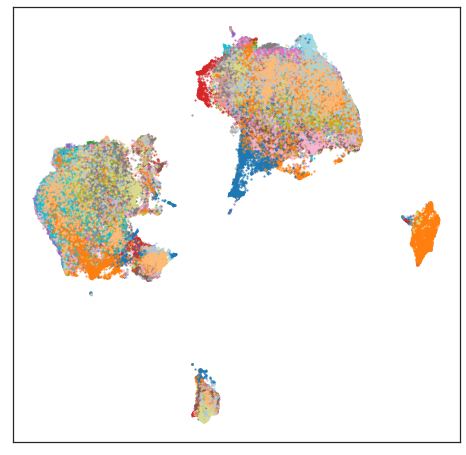

In [15]:
ax = single_cell_plot(data=sample,
                      x="UMAP1",
                      y="UMAP2",
                      label="sample_id",
                      discrete=True,
                      linewidth=0,
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/batch_correction/before_tcells.png", dpi=300,
            bbox_inches="tight", facecolor="white")

<h3>After correction</h3>

In [16]:
harmony.run(sigma=0.1)

2021-03-04 10:52:48,014 - harmonypy - INFO - Iteration 1 of 10
2021-03-04 10:54:46,596 - harmonypy - INFO - Iteration 2 of 10
2021-03-04 10:56:38,299 - harmonypy - INFO - Iteration 3 of 10
2021-03-04 10:58:30,193 - harmonypy - INFO - Iteration 4 of 10
2021-03-04 11:00:30,148 - harmonypy - INFO - Iteration 5 of 10
2021-03-04 11:02:41,010 - harmonypy - INFO - Iteration 6 of 10
2021-03-04 11:04:27,497 - harmonypy - INFO - Iteration 7 of 10
2021-03-04 11:05:55,143 - harmonypy - INFO - Iteration 8 of 10
2021-03-04 11:07:07,721 - harmonypy - INFO - Iteration 9 of 10
2021-03-04 11:08:06,356 - harmonypy - INFO - Converged after 9 iterations


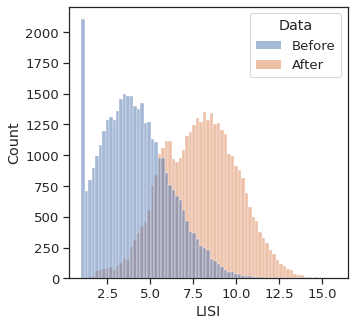

In [14]:
harmony.batch_lisi_distribution(sample=0.1)
plt.savefig(f"figures/tcells_lisi.png",
            facecolor="white",
            dpi=300,
            bbox_inches="tight")

In [17]:
after = harmony.batch_corrected().iloc[sample.index.values]

In [18]:
embeddings = reducer.transform(after[harmony.features])

In [19]:
after["UMAP1"], after["UMAP2"] = embeddings[:, 0], embeddings[:, 1]

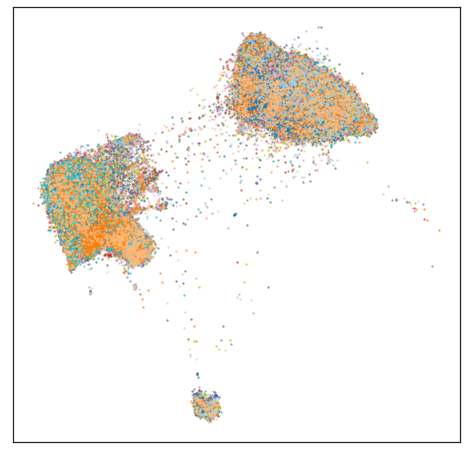

In [21]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="sample_id",
                      discrete=True,
                      linewidth=0,
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/batch_correction/after_tcells.png", dpi=300, bbox_inches="tight", facecolor="white")

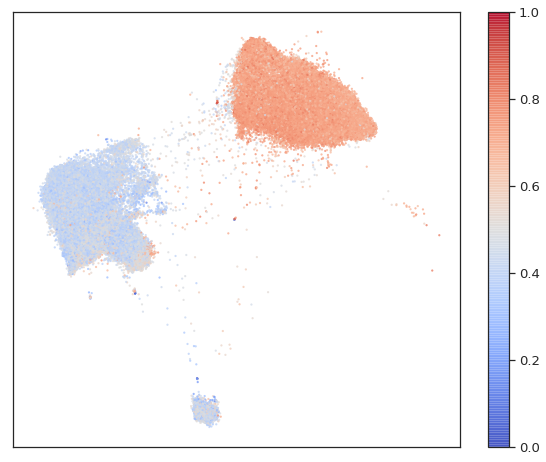

In [28]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD4",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      norm=Normalize(vmin=0.0, vmax=1.0),
                      cmap="coolwarm",
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_CD4_tcells.png", dpi=300, bbox_inches="tight", facecolor="white")

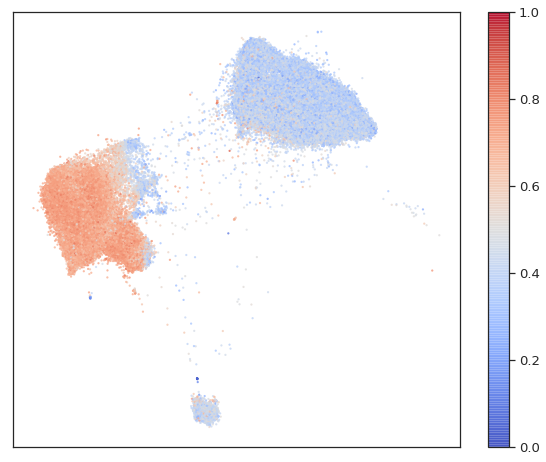

In [29]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD8",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      norm=Normalize(vmin=0.0, vmax=1.0),
                      cmap="coolwarm",
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_CD8_tcells.png", dpi=300, bbox_inches="tight", facecolor="white")

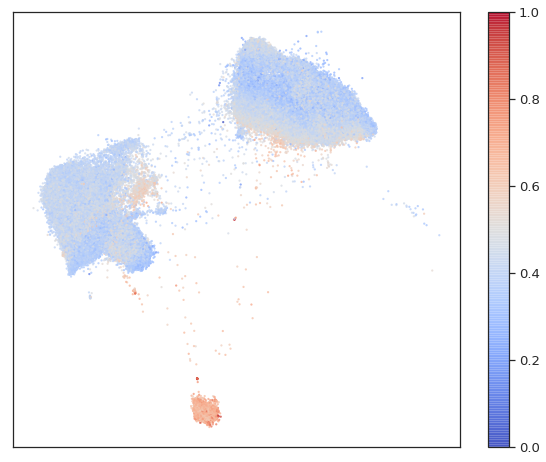

In [30]:
after["PanGD + Vd2"] = after["PanGD"] + after["Vd2"]
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="PanGD + Vd2",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      norm=Normalize(vmin=0.0, vmax=1.0),
                      cmap="coolwarm",
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_GDT_tcells.png", dpi=300, bbox_inches="tight", facecolor="white")

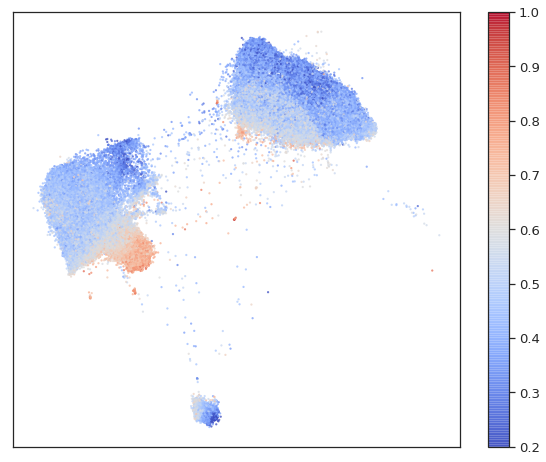

In [32]:
after["CD161 + Va7-2"] = after["CD161"] + after["Va7-2"]
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD161 + Va7-2",
                      discrete=False,
                      linewidth=0,
                      figsize=(10, 8),
                      norm=Normalize(vmin=0.2, vmax=1.0),
                      cmap="coolwarm",
                      scale="minmax",
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_MAIT_tcells.png", dpi=300, bbox_inches="tight", facecolor="white")

<h3>Saving results</h3>

In [26]:
harmony.save(experiment=project.load_experiment("Corrected drain fluid T cells"))

  0%|          | 0/44 [00:00<?, ?it/s]

<h2>Leukocyte staining</h2>

In [33]:
exp = project.load_experiment("Drain fluid Leukocytes")

In [34]:
features = ['FSC-A', 'SSC-A', 'CD14', 'CD16', 'Siglec8',
            'CD3', 'CD1c', 'CD15', 'HLA-DR', 'CD116', 
            'CD19']

In [10]:
corrected_exp = variance.create_experiment(project=project,
                                          features=features,
                                          experiment_name="Corrected drain fluid Leukocytes",
                                          data_directory="/media/ross/SP PHD U3/PD_Immunofingerprints")

In [35]:
import logging
transform_kwargs = {"m": 4, "w": 1.0}
harmony = variance.Harmony(experiment=exp,
                           features=features,
                           population="Live CD45+ cells",
                           logging_level=logging.INFO,
                           transform="logicle",
                           transform_kwargs=transform_kwargs,
                           sample_size=50000)

  0%|          | 0/47 [00:00<?, ?it/s]

/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 50000, returning complete data (n=2168)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 50000, returning complete data (n=45929)
  warn(f"Number of observations larger than requested sample size {sample_size}, "


In [36]:
harmony.data = harmony.data.reset_index(drop=True)
sample = harmony.data.sample(100000)

In [37]:
sample, reducer = dimensionality_reduction(data=sample,
                                            features=harmony.features,
                                            method="UMAP",
                                            n_components=2,
                                            return_reducer=True)

<h3>Before correction</h3>

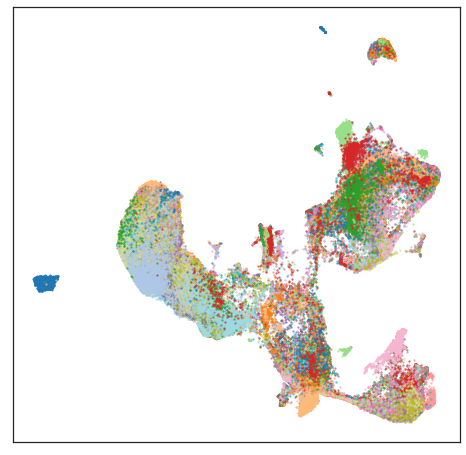

In [38]:
ax = single_cell_plot(data=sample,
                      x="UMAP1",
                      y="UMAP2",
                      label="sample_id",
                      discrete=True,
                      linewidth=0,
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/before_correction_leukocytes.png", dpi=300, bbox_inches="tight", facecolor="white")

<h3>After correction</h3>

In [39]:
harmony.run(sigma=0.1, max_iter_harmony=5)

2021-03-04 11:27:37,821 - harmonypy - INFO - Iteration 1 of 5
2021-03-04 11:39:59,874 - harmonypy - INFO - Iteration 2 of 5
2021-03-04 11:53:32,128 - harmonypy - INFO - Iteration 3 of 5
2021-03-04 12:05:38,286 - harmonypy - INFO - Iteration 4 of 5
2021-03-04 12:17:35,033 - harmonypy - INFO - Iteration 5 of 5
2021-03-04 12:29:36,717 - harmonypy - INFO - Stopped before convergence


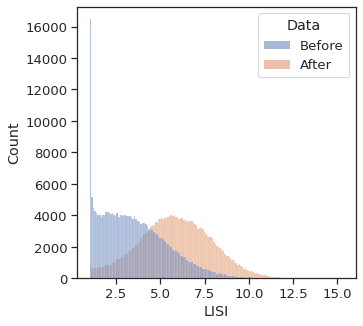

In [19]:
harmony.batch_lisi_distribution(sample=0.1)
plt.savefig(f"figures/leukocytes_lisi.png",
            facecolor="white",
            dpi=300,
            bbox_inches="tight")

In [40]:
after = harmony.batch_corrected().iloc[sample.index.values]

In [41]:
embeddings = reducer.transform(after[harmony.features])

In [42]:
after["UMAP1"], after["UMAP2"] = embeddings[:, 0], embeddings[:, 1]

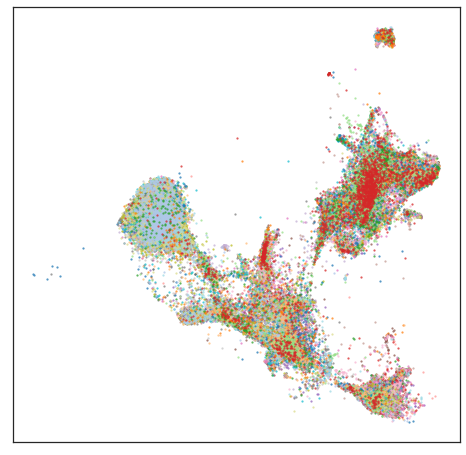

In [43]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="sample_id",
                      discrete=True,
                      linewidth=0,
                      size=5)[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("figures/after_correction_leukocytes.png", dpi=300, bbox_inches="tight", facecolor="white")

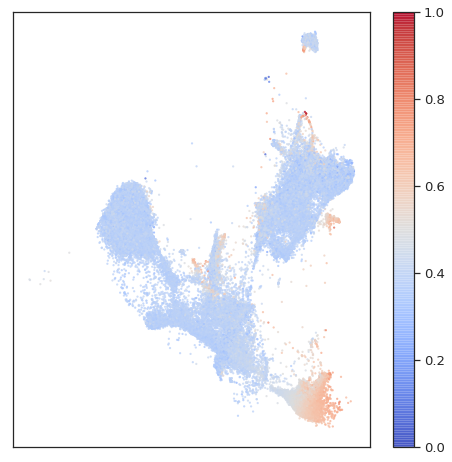

In [44]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD3",
                      discrete=False,
                      linewidth=0,
                      size=5,
                      norm=Normalize(vmin=0, vmax=1.),
                      cmap="coolwarm",
                      scale="minmax")[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

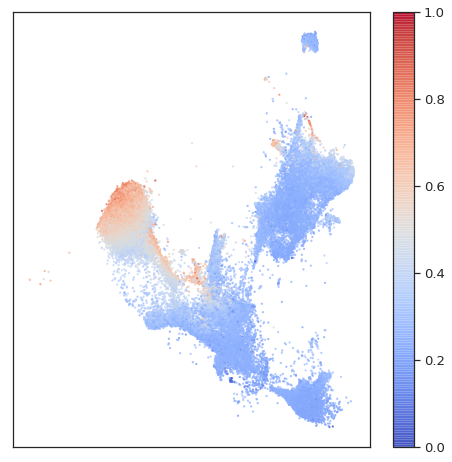

In [45]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD15",
                      discrete=False,
                      linewidth=0,
                      size=5,
                      norm=Normalize(vmin=0, vmax=1.),
                      cmap="coolwarm",
                      scale="minmax")[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

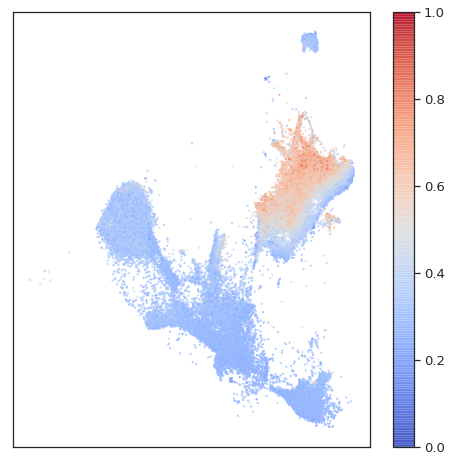

In [46]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD14",
                      discrete=False,
                      linewidth=0,
                      size=5,
                      norm=Normalize(vmin=0, vmax=1.),
                      cmap="coolwarm",
                      scale="minmax")[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

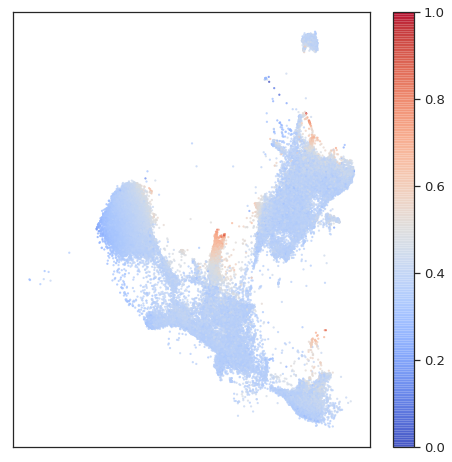

In [47]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="Siglec8",
                      discrete=False,
                      linewidth=0,
                      size=5,
                      norm=Normalize(vmin=0, vmax=1.),
                      cmap="coolwarm",
                      scale="minmax")[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

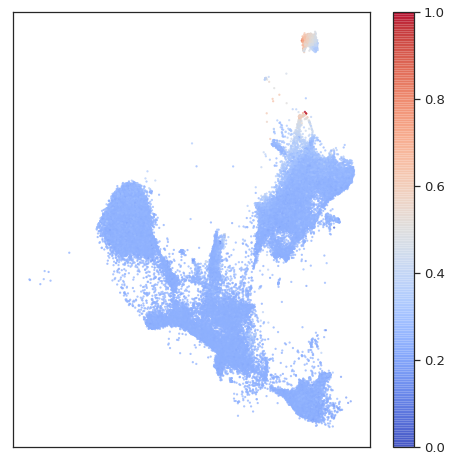

In [48]:
ax = single_cell_plot(data=after,
                      x="UMAP1",
                      y="UMAP2",
                      label="CD19",
                      discrete=False,
                      linewidth=0,
                      size=5,
                      cmap="coolwarm",
                      norm=Normalize(vmin=0, vmax=1.0),
                      scale="minmax")[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

<h3>Saving results</h3>

In [34]:
harmony.save(experiment=project.load_experiment("Corrected drain fluid Leukocytes"))

  0%|          | 0/47 [00:00<?, ?it/s]